# Visualising 4D Free Energy Surfaces and their minimum Free Energy paths
- This is a notebook for visualising FESs spanned by 3 CVs
- It also contains code to identify the minimum energy path from any point in the surfaces to the global minimum
- The inputs required are file containing a set of 3D points and a list of weights associated with each point

In [1]:
import numpy as np
from numpy import inf
import scipy.stats as sts
import matplotlib.pyplot as plt

In [2]:
kT=8.314462618e-3*1100
CVs = np.loadtxt("data/CVs_3D.dat")
weights = np.loadtxt("data/Weights.dat")

In [3]:
def construct_FES(CVs, weights, kT, num_bins=50j, band_width="scott"):
    """Construct a Free Energy Surface over a 3 dimensional grid of specified resolution from the provided points in CV space
    using weighted 3 dimensional kernel density estimation.

    :param CVs: List of points in CV space
    :type CVs: nd.array
    :param weights: List of weights corresponding to each point
    :type weights: nd.array
    :param kT: Value of kT
    :type kT: float
    :param num_bins: Resolution of the 3D grid (see np.mgrid), defaults to 50j
    :type num_bins: complex, optional
    :param band_width: Can be any valid value for the band_with parameter in sts.gaussian_kde 
    :return: Grid representing the FES and the coordinates spanning the grid
    :rtype: nd.array
    """
    X_r, Y_r, Z_r = np.mgrid[CVs[:,0].min():CVs[:,0].max():num_bins, CVs[:,1].min():CVs[:,1].max():num_bins, CVs[:,2].min():CVs[:,2].max():num_bins]
    positions = np.vstack([X_r.ravel(), Y_r.ravel(), Z_r.ravel()])
    values = np.vstack([CVs[:,0], CVs[:,1], CVs[:,2]])
    kde = sts.gaussian_kde(values, weights=weights, bw_method=band_width)
    Z = np.reshape(kde(positions).T, X_r.shape)

    FES = -kT*np.log(Z)-np.min(-kT*np.log(Z))

    return FES, [X_r, Y_r, Z_r]

In [4]:
FES, grid_coords = construct_FES(CVs, weights, kT)

/tmp/ipykernel_29710/3357695372.py:23: RuntimeWarning: divide by zero encountered in log
  FES = -kT*np.log(Z)-np.min(-kT*np.log(Z))


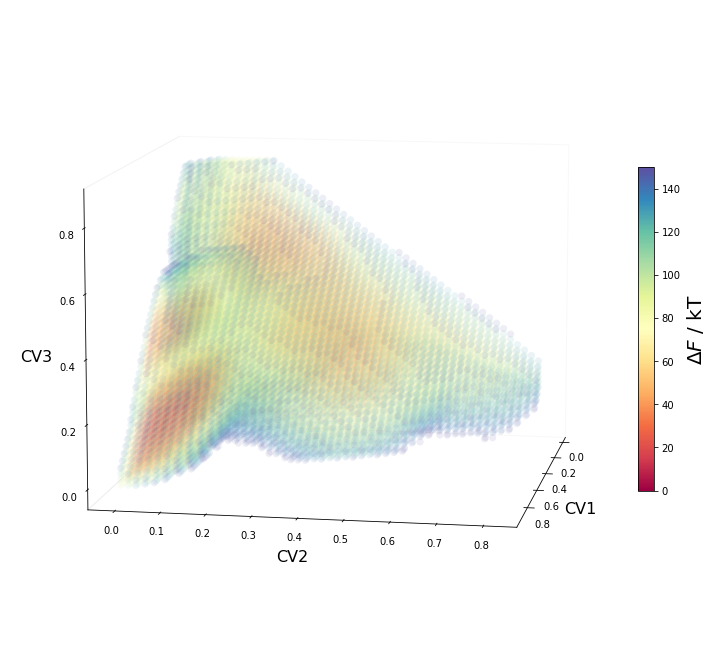

In [5]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection="3d")
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False

# Display all points with a Free Energy less than 150
mask = FES < 150

# Adjust scale and alpha accordingly
cp = ax.scatter(grid_coords[0], grid_coords[1], grid_coords[2], c=FES.flatten(), s=50.0 * mask, edgecolor="face", alpha=0.1, marker="o", cmap="Spectral", linewidth=0, vmax=150)
# Adjust the size and position of the colourbar
cbar = plt.colorbar(cp, ax=ax, fraction=0.025, pad=-0.02)
cbar.set_label("$\Delta F$ / kT",fontsize=20)
# Make the Colourbar non-transparent
cbar.set_alpha(1)
cbar.draw_all()

ax.set_xlabel("CV1", fontsize=16, labelpad=10)
ax.set_ylabel("CV2", fontsize=16, labelpad=10)
ax.set_zlabel("CV3", fontsize=16, labelpad=10)
ax.grid(False)
plt.tight_layout()
# Rotate the axes and update
ax.view_init(10, 10)

plt.show()

## Identifying Minimum Free Energy Paths

In [12]:
np.shape(FES)[0]

50

In [16]:
def Score_FES(FES):
    """Path finding algorithm inspired by Dijkstra's algorithm. This function prepares a copy of the FES grid where each point is scored based on its "Free Energy Distance" to the global minimum.
    Performing a greedy search on the returned grid yields the Minimum Free Energy Path from any point to the global minimum.

    :param FES: Grid representing the 3D FES
    :type FES: nd.array
    :return: Grid containing the scored FES
    :rtype: nd.array
    """

    # Define all the directions in which to look for neighbours
    directions = []
    for m in range(-1, 2):
        for n in range(-1, 2):
            for k in range(-1, 2):
                directions.append(np.array([m, n, k]))

    directions.pop(13)
    directions = np.array(directions)

    # Point with the minimal FE
    start = np.argwhere(FES == np.min(FES))[0]
    # New grid where -inf represents unvisited nodes
    F_update = np.ones(np.shape(FES))*-inf
    # Set the starting point to 0
    F_update[tuple(start)] = 0

    num_bins = np.shape(FES)[0]
    # Find the first neighbourshell
    neighbours = directions + start

    # Filter out any neighbours that leave the grid
    neighbours = neighbours[np.all(neighbours >= 0, axis=1)]
    neighbours = neighbours[np.all(neighbours < num_bins, axis=1)]

    # Set the weights of all first shell neighbours to their real values
    for n in neighbours:
        F_update[tuple(n)] = FES[tuple(n)]
    
    # Start pulsing through the graph until every node has been updated
    while -inf in F_update:
        # list of neighbours of the current shell
        next_shell = {}
        # For each node in the neighbourlist

        for i in range(len(neighbours)):
            # find its neighbours
            n_neigh = directions + neighbours[i]
            # Eliminate all that leave the grid
            n_neigh = n_neigh[np.all(n_neigh >= 0, axis=1)]
            n_neigh = n_neigh[np.all(n_neigh < num_bins, axis=1)]
        
           # Eliminate all that have been visited
            mask = []
            for j in range(len(n_neigh)):
                if F_update[tuple(n_neigh[j])] == -inf:
                    mask.append(j)
            n_neigh = n_neigh[mask]

            for j in range(len(n_neigh)):
                neigh_ind = tuple(n_neigh[j])
                origin_ind = tuple(neighbours[i])
                # Check if the neighbour is known
                if neigh_ind in next_shell:
                    # Set the dictionary entry to the lower of the two scores
                    # Score is the value of the next_shell member in the real grid
                    # Plus the value of the origin node in the score grid
                    next_shell[neigh_ind] = min(next_shell[neigh_ind], FES[neigh_ind] + F_update[origin_ind])
                else:
                    next_shell[neigh_ind] = FES[neigh_ind] + F_update[origin_ind]
                
        # The new shell now has its lowest possible score assigned through the dictionary
        # Enter the Scores into the score grid
        # And make the new shell the new list of neighbours

        neighbours = []
    
        for n in next_shell:
            F_update[n] = next_shell[n]
            neighbours.append(np.array(n))
        
        neighbours = np.array(neighbours)


        # Print progress
        print("Grid is scored %f %%\r" % (len(np.where(F_update != -inf)[1]) / len(F_update.ravel())* 100), end="")

    return F_update

In [17]:
F_scored = Score_FES(FES)

In [22]:
def greedy_path_finding(F_scored, start):
    """A greedy path finding algorithm that returns the path from the start to the global minimum of the given FES via the lowest scored immediate neighbour.

    :param F_scored: Grid representing a FES (should be scored)
    :type F_scored: nd.array
    :param start: index of the starting point
    :type start: Tuple
    :return: List of tuples representing the found path.
    :rtype: List
    """
    # Define all the directions in which to look for neighbours
    directions = []
    for m in range(-1, 2):
        for n in range(-1, 2):
            for k in range(-1, 2):
                directions.append(np.array([m, n, k]))

    i = start[0]
    j = start[1]
    k = start[2]
    path = [(i, j, k)]

    while F_scored[i][j][k] != np.min(F_scored):
        tup = np.array([i, j, k])
        neighbours = directions + tup
        neighbours = neighbours[np.all(neighbours >= 0, axis=1)]
        Fmin = inf
        tup_min = tup
        Fcurr = F_scored[tuple(tup)]
        for n in neighbours:
            F = F_scored[tuple(n)]
            if F == Fcurr:
                continue
            if (F < Fmin) and (not tuple(n) in path):
            
                Fmin = F
                tup_min = n
    
        path.append(tuple(tup_min))
        i = tup_min[0]
        j = tup_min[1]
        k = tup_min[2]

    return path 

In [43]:
mep = greedy_path_finding(F_scored, (0, 0, 0))

In [44]:
mep_coords = []
for i in range(len(mep)):
    x = grid_coords[0][mep[i]]
    y = grid_coords[1][mep[i]]
    z = grid_coords[2][mep[i]]
    mep_coords.append(np.array([x,y,z]))
mep_coords = np.array(mep_coords)

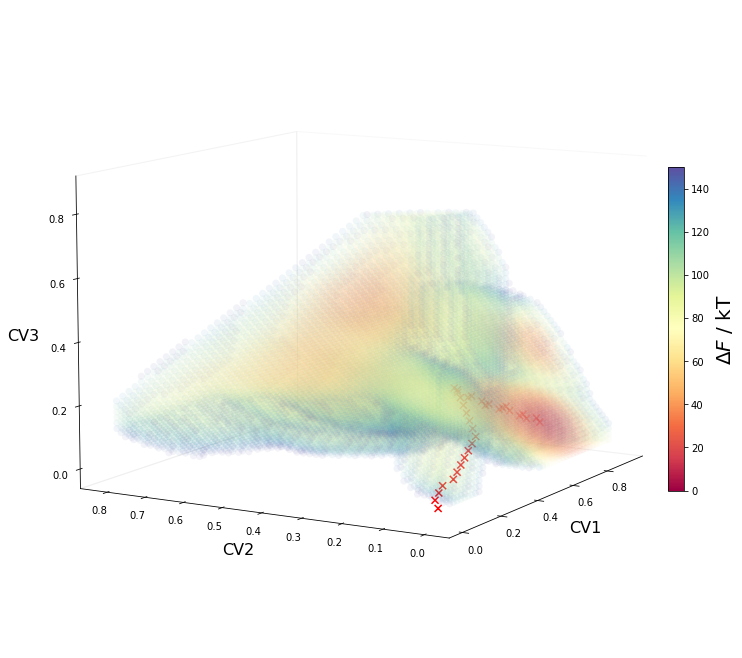

In [49]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection="3d")
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False

# Display all points with a Free Energy less than 150
mask = FES < 150

# Adjust scale and alpha accordingly
cp = ax.scatter(grid_coords[0], grid_coords[1], grid_coords[2], c=FES.flatten(), s=50.0 * mask, edgecolor="face", alpha=0.07, marker="o", cmap="Spectral", linewidth=0, vmax=150)
# Adjust the size and position of the colourbar
cbar = plt.colorbar(cp, ax=ax, fraction=0.025, pad=-0.02)
cbar.set_label("$\Delta F$ / kT",fontsize=20)
# Make the Colourbar non-transparent
cbar.set_alpha(1)
cbar.draw_all()

ax.scatter(mep_coords[:,0], mep_coords[:,1], mep_coords[:,2], s=50, marker="x", color="red", label="MEP")

ax.set_xlabel("CV1", fontsize=16, labelpad=10)
ax.set_ylabel("CV2", fontsize=16, labelpad=10)
ax.set_zlabel("CV3", fontsize=16, labelpad=10)
ax.grid(False)
plt.tight_layout()
# Rotate the axes and update
ax.view_init(10, 210)

plt.show()

In [41]:
mep = greedy_path_finding(F_scored, (10, 20, 40))
mep_coords = []
for i in range(len(mep)):
    x = grid_coords[0][mep[i]]
    y = grid_coords[1][mep[i]]
    z = grid_coords[2][mep[i]]
    mep_coords.append(np.array([x,y,z]))
mep_coords = np.array(mep_coords)

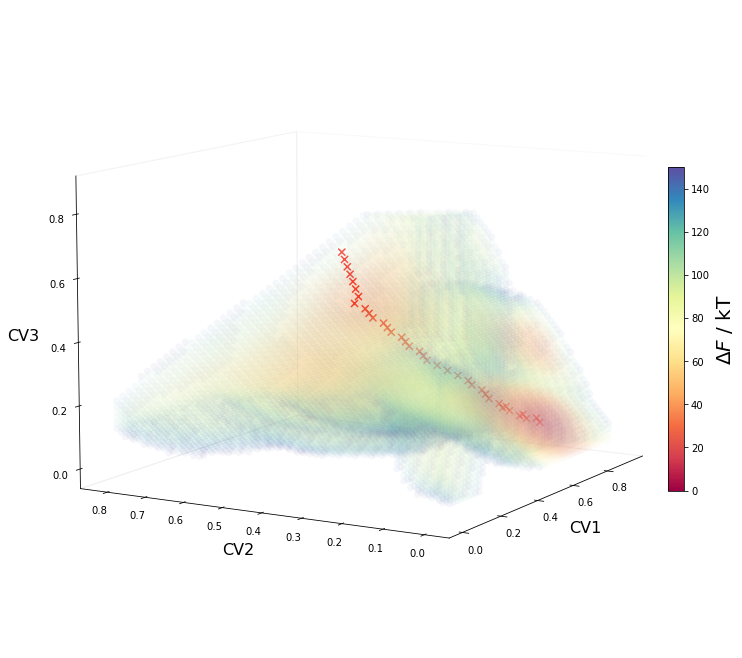

In [42]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection="3d")
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False

# Display all points with a Free Energy less than 150
mask = FES < 150

# Adjust scale and alpha accordingly
cp = ax.scatter(grid_coords[0], grid_coords[1], grid_coords[2], c=FES.flatten(), s=50.0 * mask, edgecolor="face", alpha=0.05, marker="o", cmap="Spectral", linewidth=0, vmax=150)
# Adjust the size and position of the colourbar
cbar = plt.colorbar(cp, ax=ax, fraction=0.025, pad=-0.02)
cbar.set_label("$\Delta F$ / kT",fontsize=20)
# Make the Colourbar non-transparent
cbar.set_alpha(1)
cbar.draw_all()

ax.scatter(mep_coords[:,0], mep_coords[:,1], mep_coords[:,2], s=50, marker="x", color="red")
ax.set_xlabel("CV1", fontsize=16, labelpad=10)
ax.set_ylabel("CV2", fontsize=16, labelpad=10)
ax.set_zlabel("CV3", fontsize=16, labelpad=10)
ax.grid(False)
plt.tight_layout()
# Rotate the axes and update
ax.view_init(10, 210)

plt.show()